<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn


In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list -s "ovarian cancer"

ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2854         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3464         48  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1515         38  1.0          

In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Define dataset path
DATASET_PATH = "OvarianCancer"

# Cancer classes (based on folder names)
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}

# Image size for EfficientNetV2
IMG_SIZE = 224

# Lists to store images & labels
X, y = [], []

# Load images dynamically
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)

    if not os.path.exists(class_path):
        continue  # Skip if folder doesn't exist

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip unreadable images

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)  # EfficientNetV2 preprocessing
        X.append(img)
        y.append(class_mapping[class_name])  # Assign label

# Convert to NumPy arrays
X = np.array(X)
y = to_categorical(y, num_classes=len(classes))  # One-hot encode labels

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset loaded: {len(X)} images")


Dataset loaded: 497 images


In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load pre-trained EfficientNetV2 (S = small version)
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Unfreeze last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(classes), activation="softmax")(x)

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train, y_train, batch_size=16)

# Train the model
history = model.fit(train_generator, validation_data=(X_test, y_test), epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 407s 12s/step - accuracy: 0.3895 - loss: 2.5847 - val_accuracy: 0.5900 - val_loss: 1.2472
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 295s 12s/step - accuracy: 0.6211 - loss: 1.4853 - val_accuracy: 0.6300 - val_loss: 1.7560
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 286s 11s/step - accuracy: 0.6911 - loss: 1.3001 - val_accuracy: 0.6400 - val_loss: 5.9532
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 320s 11s/step - accuracy: 0.5832 - loss: 1.7504 - val_accuracy: 0.6700 - val_loss: 2.2273
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 323s 11s/step - accuracy: 0.6135 - loss: 1.4917 - val_accuracy: 0.7000 - val_loss: 0.7159
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 287s 12s/step - accuracy: 0.6828 - loss: 1.3666 - val_accuracy: 0.7900 - val_loss: 1.0860
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 290s 12s/step - accuracy: 0.6872 - loss: 1.3790 - val_accuracy: 0.6500 - val_loss: 0.8491
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 285s 11s/step - accuracy: 0.7484 - loss: 0.9971 - val_accuracy: 0.

In [10]:
# Evaluate model performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Loss: {loss:.4f}")

# Save the model
model.save("efficientnetv2_ovarian_cancer_model.h5")
print("Model saved successfully!")


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.8490 - loss: 0.5929


Test Accuracy: 0.87
Test Loss: 0.5054
Model saved successfully!


In [12]:
import cv2
import numpy as np
import os

def predict_image(image_path):
    if not os.path.exists(image_path):
        print(f"Error: File not found -> {image_path}")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image -> {image_path}")
        return

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize safely
    img = np.expand_dims(img, axis=0)  # Expand dimensions for model input
    img = preprocess_input(img)  # EfficientNetV2 preprocessing

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)  # Get highest probability class
    class_names = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]

    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"Prediction Confidence: {prediction[0][predicted_class]*100:.2f}%")

# Example: Test on an image
predict_image("OvarianCancer/Mucinous/sample_image.jpg")  # Replace with actual image path


Error: File not found -> OvarianCancer/Mucinous/sample_image.jpg


In [13]:
import os

folder_path = "OvarianCancer/Mucinous"  # Change folder if needed

if os.path.exists(folder_path):
    print("Files in directory:", os.listdir(folder_path))
else:
    print("Error: Folder does not exist!")


Files in directory: ['mucinus53.JPG', 'mucinus33.JPG', 'mucinus60.JPG', 'image_Mucinous_0_9205.jpg', 'mucinus45.JPG', 'mucinus18.JPG', 'image_Mucinous_0_2479.jpg', 'mucinus77JPG.JPG', 'mucinus41.JPG', 'image_Mucinous_0_5463.jpg', 'mucinus77.JPG', 'image_Mucinous_0_3917.jpg', 'mucinus70.JPG', 'mucinus61.JPG', 'image_Mucinous_0_5486.jpg', 'image_Mucinous_0_4165.jpg', 'mucinus34.JPG', 'mucinus62.JPG', 'mucinus67.JPG', 'mucinus65.JPG', 'mucinus8.JPG', 'mucinus73.JPG', 'mucinus31.JPG', 'mucinus4.JPG', 'image_Mucinous_0_4880.jpg', 'image_Mucinous_0_9331.jpg', 'mucinus59.JPG', 'mucinus49.JPG', 'mucinus66.JPG', 'mucinus2.JPG', 'mucinus27.JPG', '71.JPG', 'mucinus35.JPG', 'mucinus39.JPG', 'image_Mucinous_0_8239.jpg', 'mucinus76.JPG', 'mucinus68.JPG', 'mucinus72JPG.JPG', 'image_Mucinous_0_4376.jpg', 'mucinus3.JPG', 'mucinus11.JPG', 'mucinus21.JPG', 'mucinus63.JPG', 'mucinus28.JPG', 'image_Mucinous_0_5458.jpg', 'mucinus50.JPG', 'mucinus48.JPG', 'mucinus10.JPG', 'mucinus12.JPG', 'mucinus51.JPG', 'i

In [14]:
predict_image("OvarianCancer/Mucinous/mucinus53.JPG")  # Replace with a valid image filename


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: Non_Cancerous
Prediction Confidence: 75.74%


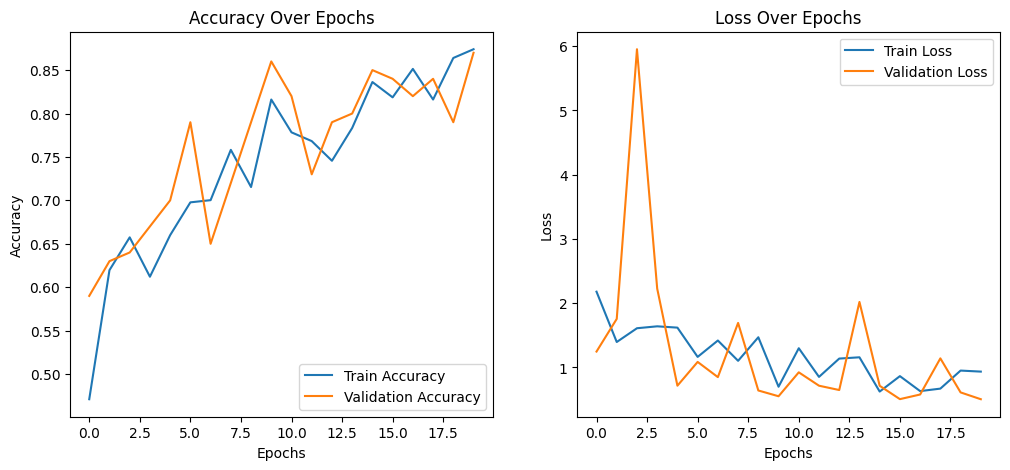

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
